## Basics

We will here simulate Curli growth on one bacteria.

Curli formation has two important microscopic reaction steps; nucleation, and elongation. Nucleation is when a CsgB monomer attaches to the cell membrane to start a new curli fibril. Elongation is when a CsgA monomer attaches to a fibril end.

CsgA and CsgB monomers are produced by bacteria cells, and secreted through the membrane. The CsgA monomers then have to diffuse to the fibril end to enable elongation. As the diffusion rate of CsgA and CsgB are on the scale micrometers/s, approximating a homogenuous concentration in space is possible. The concentration is, however, not constant in time, as monomers are created, adsorbed, and degrading.

In essence, the model needs to simulate monomer concentration changes, fibril nucleations, and fibril elongations. The position and distrubution of fibrils is also of interest.

First of all, there need to be some systems imported for the code to work. The programs randomCompexAddition, numericaldiffusion and curliutil are utiliary programs which will make this program easier to write by doing small repetitive tasks.

In [104]:
import numpy as np
import randomComplexAddition
from numericaldiffusion import inhibitedCsgAC
import curliutil
import cmath
from scipy.constants import N_A
import copy

Next up we need a class for the fibrils. We need to keep track of angularity relative to the bacterial cell (alpha), the position of the fibril end (pos), and the number of monomers added to each fibril (size). We also include the length of one subunit ($UNITL$), the average angle deviation between two subunits ($SIGMA$), and the elongation rate ($KPLUS$).

In [105]:
class CurliFibril(object):
    SIGMA = 3.47 #degrees
    KPLUS = 21000 #/mol s
    UNITL = 4e-9

    def __init__(self, index):
        self.pos = 0
        self.alpha = np.random.normal(0,self.SIGMA*np.pi/180)
        self.size = 1
        self.index = index
    
    def __lt__(self, other):
        if self.pos < other.pos:
            return True
        return False


We will now create a class that can manage the molecular interactions. The rate equation for curli elongation is
$$\frac{dM}{dt} = k_+ [CsgA] [Endpoints]$$
were $\frac{dM}{dt}$ is the Curli mass increase, $k_+$ is the elongation rate, $[CsgA]$ and $[Endpoints]$ is the CsgA and Curli endpoint concentrations, respectively. We can simulate the equation numerically by drawing the number of Curli fibrils that will be elongated at a given timestep from the poisson distribution with the expected value $\lambda = k_+ [CsgA][Endpoints]dt$. We can simulate CsgB secretion by using a poisson distribution with the expected value $\lambda = p_B dt$, where $p_B$ is the CsgB production rate. 

To be able to simulate more advanced dynamics such as diffusion, and to be able to extract the necessairy data, we need to keep track of every fibril endpoint. 
At every time step, we will do the following:
<ul>
    <li> Randomly select how many endpoints to elongate from the poisson distribution (=N)</li>
    <li> Randomly select N endpoints to elongate </li> 
    <li> Elongate the chosen endpoints and adjust the CsgA concentrations accordingly</li>
    <li> Randomly select how many new fibrils should be formed. </li>
    <li> Compensate CsgA concentration to the newly secreted monomers </li>
</ul>

In [106]:
class UniformFibrilFormation(object): 
    def __init__(self, dist, xsteps, deltat,  inhibitors = [], cBacteria=1e12, initial_concentration = None, fibril0 = None):
        self.dist = dist
        self.CSGBRATE = 1.3e-13*N_A/cBacteria #n / bac / s
        self.xsteps = xsteps
        self.deltat = deltat
        self.deltax = dist / xsteps
        self.cBacteria = cBacteria
        if initial_concentration == None:
            self.C = inhibitedCsgAC(dist, xsteps, deltat, cBacteria, how = 'uniform',c0=None, inhibitors=inhibitors)
        else:
            self.C = initial_concentration
        
        if fibril0 == None:
            self.endpointSets = [curliutil.ListDict() for _ in range(xsteps)]
            self.massProfile = np.zeros(xsteps)
            self.index = 0
            self.totalMass = 0
        else:
            self.endpointSets = copy.deepcopy(fibril0.endpointSets)
            self.massProfile = copy.deepcopy(fibril0.massProfile)
            self.index = copy.deepcopy(fibril0.index)
            self.totalMass = copy.deepcopy(fibril0.totalMass)
            self.C.c = copy.deepcopy(fibril0.C.c)
    
    def getTime(self):
        return self.C.time
    def getMass(self):
        return self.totalMass
    def getFibrils(self):
        fibrils = []
        for i in self.endpointSets:
            fibrils += i.items
        return fibrils
    def getConcentration(self):
        return self.C.c
    def getMassProfile(self):
        return self.massProfile
    
    def elongate(self,fibril):
        pos0 = fibril.pos
        fibril.alpha += np.random.normal(0,fibril.SIGMA*np.pi/180)
        fibril.size += 1
        fibril.pos += fibril.UNITL*np.cos(fibril.alpha)
        diff = fibril.pos % self.deltax
        fi = lambda i : int(np.floor(i))
        self.totalMass += 1
        self.massProfile[fi(fibril.pos / self.deltax)] += 1 
        
    def timeStep(self):
        for x in np.random.choice([*range(self.xsteps)], size=self.xsteps, replace=False):
            if len(self.endpointSets[x]) > 0:
                kwrates = {'kplus':CurliFibril.KPLUS}
                for inh in self.C.inhibitors:
                    kwrates = inh.rateFunc(self.C, kwrates)
                
                mC = self.C.c
                fN = len(self.endpointSets[x])
                dV = 1/self.cBacteria #The volume occupied by one bacteria in 1e12 bac/dm3 sol.
                mN = mC * N_A * dV
                nElongations = int(np.random.poisson(max(kwrates['kplus'] * fN* mC*self.deltat,0)))
                toElongate = np.random.choice(fN, size=nElongations)
                toElongate = list(map(lambda f : self.endpointSets[x].items[f], toElongate))
                list(map(self.elongate, toElongate))
                list(map(lambda f: self.endpointSets[x].remove(f), toElongate))
                try:
                    for f in set(toElongate):
                        if f.pos > 0:
                            self.endpointSets[int(f.pos // self.deltax)].add(f)
                except IndexError:
                    raise "Dist too small. Fibril out of bounds."
                
                mN -= nElongations
                self.C.c = mN / dV /N_A
        self.C.timeStep()
        nNewFibrils = np.random.poisson(self.CSGBRATE * self.deltat)
        list(map(lambda f : self.endpointSets[0].add(CurliFibril(f)), range(self.index, self.index + nNewFibrils)))
        self.index += nNewFibrils
        
        if self.C.c > 10*self.C.time*self.C.ke:
            raise ValueError('Total fibril concentration much greater than production')

As previously discussed, diffusion is a key factor in the formation of Curli fibers. CsgA monomers needs to diffuse to the Curli endpoints in order for them to attach. In order to facilitate flexabillity of the model, we implemented a more complex model that incorperates the diffusion physics. However, we have found that the diffusion of CsgA is fast enough to warrant a model with spatially constant concentrations.

In [107]:
class DiffusiveFibrilFormation(UniformFibrilFormation):
    def __init__(self, dist, xsteps, deltat,  inhibitors=[], cBacteria=1e12, concentrationProfile = None, fibril0 = None):
        super().__init__(dist, xsteps, deltat, inhibitors, cBacteria,concentrationProfile, fibril0)
        if concentrationProfile == None:
            self.C = inhibitedCsgAC(dist, xsteps, deltat, cBacteria, how = 'spherical',U0=None, inhibitors=inhibitors)
        else:
            self.C = concentrationProfile

    def timeStep(self):
        for x in np.random.choice([*range(self.xsteps)], size=self.xsteps, replace=False):
            if len(self.endpointSets[x]) > 0 and self.C.U[x,0] > 0:
                mC = self.C.U[x,0]
                fN = len(self.endpointSets[x])
                xPos = x*self.deltax + self.C.R0
                dV = 4/3*np.pi*((xPos+self.deltax)**3 - xPos**3)*1e3
                mN = mC * N_A * dV
                nElongations = int(np.random.poisson(max(CsgAFibril.KPLUS* fN * mC*self.deltat,0)))
                toElongate = np.random.choice(fN, size=nElongations)
                toElongate = list(map(lambda f : self.endpointSets[x].items[f], toElongate))
                list(map(self.elongate, toElongate))
                list(map(lambda f: self.endpointSets[x].remove(f), toElongate))
                try:
                    for f in set(toElongate):
                        if f.pos > 0:
                            self.endpointSets[int(f.pos // self.deltax)].add(f)
                except IndexError:
                    raise "Dist too small. Fibril out of bounds."

                mN -= nElongations
                self.C.U[x,0] = mN /dV /N_A
        self.C.timeStep()
        nNewFibrils = np.random.poisson(self.CSGBRATE * self.deltat)
        list(map(lambda f : self.endpointSets[0].add(CsgAFibril(f)), range(self.index, self.index + nNewFibrils)))
        self.index += nNewFibrils
        
        fxp = lambda x: x*self.deltax + self.C.R0
        f = lambda x: self.C.U[x,0]*(4/3*np.pi*(fxp(x)  + self.deltax)**3 - fxp(x)**3)*1e3*N_A
        if sum(map(f, range(self.xsteps))) > 10*self.C.time*self.C.ke*N_A*self.cBacteria:
            raise ValueError('Total fibril concentration much greater than production')

Now let's model the growth of curli using the classes that are defined here in this notebook. The concentration of bacteria is set to $10^{12}$ bacteria per $dm^3$, and the distance modelled from the simulated bacteria is 5 $\mu m$. The simulation takes 1000 time steps over a simulated time of 10 hours. After this a graph of mass distrubution, endpoint distrubution and distrubution of lengths between curli fibrils is displayed.

Xdist 1e-08
0.0% completed in 0.007014751434326172s. Delta T = 0.007014751434326172
Total mass: 0
10.0% completed in 0.08278894424438477s. Delta T = 0.0757741928100586
Total mass: 2802
20.0% completed in 0.3201758861541748s. Delta T = 0.23738694190979004
Total mass: 21570
30.0% completed in 0.9006168842315674s. Delta T = 0.5804409980773926
Total mass: 70653
40.0% completed in 1.8690388202667236s. Delta T = 0.9684219360351562
Total mass: 160386
50.0% completed in 3.307673215866089s. Delta T = 1.4386343955993652
Total mass: 294105
60.0% completed in 5.2011988162994385s. Delta T = 1.8935256004333496
Total mass: 469639
70.0% completed in 7.539942979812622s. Delta T = 2.3387441635131836
Total mass: 679335
80.0% completed in 10.18341588973999s. Delta T = 2.643472909927368
Total mass: 916114
90.0% completed in 13.15162467956543s. Delta T = 2.9682087898254395
Total mass: 1169413


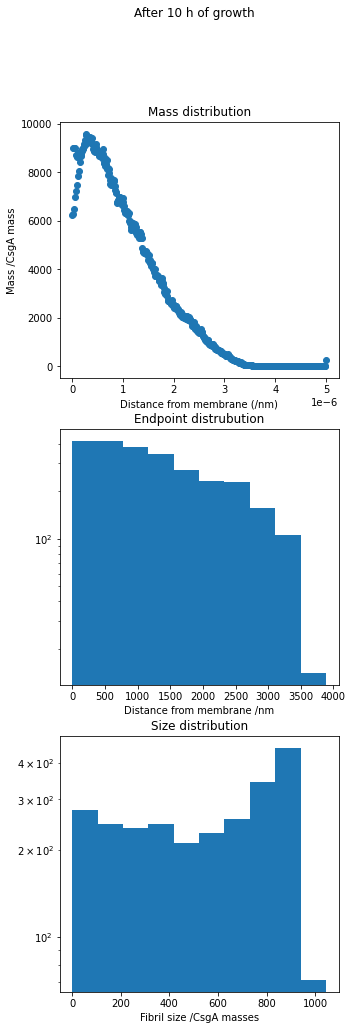

In [108]:
import time 
import matplotlib.pyplot as plt

time0 = time.time()
time1 = time.time()
timesteps = int(1000)
dist = 5e-6
xst = 500
print(f'Xdist {dist/xst}')
diffusion = UniformFibrilFormation(dist, xst, 10*3600/timesteps, cBacteria=1e12)

mass = []
timel = []
for i in range(timesteps):
    if i % (timesteps // 10) == 0:
        print("{prc}% completed in {t}s. Delta T = {dt}".format(prc = str(i / timesteps *100), t = str(time.time() - time0), dt = str(time.time() - time1)))
        print(f'Total mass: {diffusion.totalMass}')
        time1 = time.time()
    diffusion.timeStep()
    mass.append(diffusion.getMass())
    timel.append(diffusion.getTime())

fibrils = []
for i in diffusion.endpointSets:
    fibrils += i.items

xstag = np.linspace(0., dist, xst + 1)
x = (xstag[:-1] + diffusion.deltax/2)
mu = chr(956)
fig, axs = plt.subplots(3, figsize=(5,16))
fig.suptitle("After 10 h of growth")
axs[0].scatter(x, diffusion.massProfile)
axs[0].set_title('Mass distribution')
axs[0].set_xlabel('Distance from membrane (/m)')
axs[0].set_ylabel('Mass /CsgA mass')
axs[1].hist(list(map(lambda i : i.pos*1e9, fibrils)))
axs[1].set_title('Endpoint distrubution')
axs[1].set_yscale("log")
axs[1].set_xlabel('Distance from membrane /nm')
axs[2].hist(list(map(lambda i : i.size, fibrils)))
axs[2].set_title('Size distribution')
axs[2].set_yscale("log")
axs[2].set_xlabel('Fibril size /CsgA masses')

curliutil.checkMakeDir('../figures/')
plt.savefig("../figures/Curli_After_1h_spherical.png")


